In [1]:
# %load data_prep.py
# %load data_prep.py
import sys
import os
import pandas as pd
import numpy as np
import epiweeks as epi
import datetime
import argparse
import time
import re
import shutil
import pdb

from pandas import Series
from datetime import date, time, datetime, timedelta
from scipy import signal
from aw_micro import cdc_data

def data_read_and_prep(csv_path, epwk, yr, test_wks=4, wght=False, log_tr=False):
    # Read in the historical ILI data from startdate given by epwk and year from the csv_path and 
    #   create train and test set 
    cdcdf = pd.read_csv(csv_path, header=1)
    df = cdcdf.drop(["REGION", "REGION TYPE", "AGE 0-4", "AGE 25-49", "AGE 25-64", "AGE 5-24", "AGE 50-64", "AGE 65", "NUM. OF PROVIDERS"], axis=1)


    df['DATE'] = pd.to_datetime(df.apply(lambda row : epi.Week(int(row["YEAR"]), int(row["WEEK"])).startdate() ,axis=1, result_type='reduce'))

    
    week=epi.Week(yr, epwk)

    df_train = df[(df['DATE']<=pd.to_datetime(week.startdate()))]
    df_test = df[(df['DATE']>pd.to_datetime(week.startdate()))&((df['DATE']<=pd.to_datetime(week.startdate())+timedelta(weeks=test_wks)))]
    if wght:
        train = df_train['% WEIGHTED ILI']
        test = df_test['% WEIGHTED ILI']
    else:
        train = df_train['%UNWEIGHTED ILI']
        test = df_test['%UNWEIGHTED ILI']
    if log_tr:
        train = np.log(train)
        test = np.log(test)
    train.index = df_train['DATE']
    test.index = df_test['DATE']
    return train, test, df, df_train, df_test

def get_season(y,fft_len=1024,figs=False):
    f, Pxx_den = signal.periodogram(y, nfft=fft_len)
    Pxx_den = np.abs(Pxx_den)
    season_ind = round(fft_len/Pxx_den.argmax())
    print('Season index {}'.format(season_ind))
    return int(season_ind)

def hist_win(y,win):
    y_hist = y[(-win-1):-1]
    return y_hist

def prepdata_append():
    national = pd.read_csv('data/national/ILINet.csv', header=1)
    regional = national.append(pd.read_csv('data/regional/ILINet.csv', header=1))
    df = regional.append(pd.read_csv('data/state/ILINet.csv', header=1))
    return df

def prepdata(csv_path):    
    df = pd.read_csv(csv_path, na_values='X', header=1)
    df['REGION'] = df['REGION'].fillna('National')
    df['DATE'] = pd.to_datetime(df.apply(lambda row : epi.Week(int(row["YEAR"]), int(row["WEEK"])).startdate() ,axis=1, result_type='reduce'))
    return df
    
def prepdata_retro(csv_path,epwk):
    nat_csv_file = csv_path + '/' +'national/'+'ILINet_National_' + epwk + '.csv'
    df = pd.read_csv(nat_csv_file, na_values='X')
    
    hhs_csv_file = csv_path +'/'+'hhs/'+'ILINet_HHS_' + epwk + '.csv'
    df = df.append(pd.read_csv(hhs_csv_file,na_values='X'))
    df['REGION'] = df['REGION'].fillna('National')
    df['DATE'] = pd.to_datetime(df.apply(lambda row : epi.Week(int(row["YEAR"]), int(row["WEEK"])).startdate() ,axis=1, result_type='reduce'))

def prepdata_flux(csv_path,epwk):
    nat_csv_file = csv_path + '/'+'ILINet_national_' + str(epwk.year) +'EW'+ str(epwk.week) + '.csv'
    df = pd.read_csv(nat_csv_file, na_values='X')
    
    hhs_csv_file = csv_path +'/'+ 'ILINet_hhs_' + str(epwk.year) +'EW'+ str(epwk.week) + '.csv'
    df = df.append(pd.read_csv(hhs_csv_file,na_values='X'))
    df['region'] = df['region'].fillna('National')
    df['DATE'] = pd.to_datetime(df.apply(lambda row : epi.Week(int(row["year"]), int(row["week"])).startdate() ,axis=1, result_type='reduce'))

def prep_aw_data(aw_csv_path, st_id_path):
    df_ex = pd.read_csv(aw_csv_path)
    pp = pd.to_datetime([epi.Week(int(cdc_data.date2ew(d.date())[0]),int(cdc_data.date2ew(d.date())[1])).startdate() for d in pd.to_datetime(df_ex.date)])
    df_ex['ep_st_date'] = pp
    df_ex.index = pp
    df_ex.index = df_ex.index.rename('DATE')
    df_ex = df_ex[~df_ex.area_id.isin([72,78])]
    df_st_id = pd.read_csv(st_id_path)
    df_ex['REGION'] = df_ex.apply(lambda row: df_st_id[df_st_id['state']==row['area_id']]['state_name'].values[0], axis=1)

    return(df_ex)
        #df.set_index(['DATE'], inplace=True)

    #if region == 'US National':
    #    df = cdcdf[cdcdf['REGION TYPE']=='National']
    #    df['DATE'] = pd.to_datetime(df.apply(lambda row : epi.Week(int(row["YEAR"]), int(row["WEEK"])).startdate() ,axis=1, result_type='reduce'))
    #    #df.set_index(['DATE'], inplace=True)

    #elif region.isdigit():
    #    df = cdcdf[cdcdf['REGION']== "Region " + str(region)]
    #    df['DATE'] = pd.to_datetime(df.apply(lambda row : epi.Week(int(row["YEAR"]), int(row["WEEK"])).startdate() ,axis=1, result_type='reduce'))
    #    #df.set_index(['DATE'], inplace=True)

    #    #When I set the date row as the index, I can no longer access it using df['DATE]
    #else:
    #    df = cdcdf[cdcdf['REGION']==region]
    #    
    #    df['DATE'] = pd.to_datetime(df.apply(lambda row : epi.Week(int(row["YEAR"]), int(row["WEEK"])).startdate() ,axis=1, result_type='reduce'))
        #df.set_index(['DATE'], inplace=True)

    return df

def get_targets():
    targets = {"wili": "% WEIGHTED ILI", "ili": "%UNWEIGHTED ILI", "ilitotal": "ILITOTAL", "totalpatients": "TOTAL PATIENTS", "flux_wili": "weighted_ili", "flux_ili": "unweighted_ili", "flux_region_type": "region_type", "ili_region_type": "REGION TYPE", "flux_region": "region", "ili_region": "REGION"} #onset and peak week still need to be added
    return targets

In [8]:
# %load ARLR_exog.py
'''Contains functions that correspond to the ARLR method with exogenous regressors '''
from statsmodels.tsa.ar_model import AR
import numpy as np
import statsmodels.api as sm
#import matplotlib.pyplot as plt
import pandas as pd
import pdb, os
from aw_micro import cdc_data
import datetime
import configparser
import pkg_resources
import warnings
warnings.filterwarnings('ignore')
# ARLR functions
def get_bin():    
    bin_ed= [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2.0, 2.1, 2.2, 2.3, 2.4, 2.5, 2.6, 2.7, 2.8, 2.9, 3.0, 3.1, 3.2, 3.3, 3.4, 3.5, 3.6, 3.7, 3.8, 3.9, 4.0, 4.1, 4.2, 4.3, 4.4, 4.5, 4.6, 4.7, 4.8, 4.9, 5.0, 5.1, 5.2, 5.3, 5.4, 5.5, 5.6, 5.7, 5.8, 5.9, 6.0, 6.1, 6.2, 6.3, 6.4, 6.5, 6.6, 6.7, 6.8, 6.9, 7.0, 7.1, 7.2, 7.3, 7.4, 7.5, 7.6, 7.7, 7.8, 7.9, 8.0, 8.1, 8.2, 8.3, 8.4, 8.5, 8.6, 8.7, 8.8, 8.9, 9.0, 9.1, 9.2, 9.3, 9.4, 9.5, 9.6, 9.7, 9.8, 9.9, 10.0, 10.1, 10.2, 10.3, 10.4, 10.5, 10.6, 10.7, 10.8, 10.9, 11.0, 11.1, 11.2, 11.3, 11.4, 11.5, 11.6, 11.7, 11.8, 11.9, 12.0, 12.1, 12.2, 12.3, 12.4, 12.5, 12.6, 12.7, 12.8, 12.9, 13.0, 100]
    return bin_ed
 
def get_exog_reg(targ_dict):
    all_exog_rgsr = []
    for key in targ_dict:
        if key != 'target':
            all_exog_rgsr = all_exog_rgsr+targ_dict[key]
    return all_exog_rgsr

def rgsr_to_ind(exog_rgsr, allw_lags, all_exog_rgsr):
    rgsr_ind=max(allw_lags)+1+all_exog_rgsr.index(exog_rgsr)
    return rgsr_ind

def rgsrs_to_indices(lags_app, allw_lags, all_exog_rgsr):
    rgsrs_indices = []
    for ind in lags_app:
        if str(ind).isdigit():
            rgsrs_indices.append(ind)
        else:
            rgsrs_indices.append(rgsr_to_ind(ind,allw_lags,all_exog_rgsr))
    return rgsrs_indices

def ind_to_rgsr(exog_rgsr_ind, allw_lags, all_exog_rgsr):
    rgsr_name= all_exog_rgsr[exog_rgsr_ind-(max(allw_lags)+1)]
    return rgsr_name


def indices_to_rgsrs(lags_ind, allw_lags, all_exog_rgsr):
    rgsrs_names = []
    for ind in lags_ind:
        if ind <= max(allw_lags):
            rgsrs_names.append(ind)
        else:
            rgsrs_names.append(ind_to_rgsr(ind,allw_lags,all_exog_rgsr))
    return rgsrs_names

def get_stat_comp(df_nonstat, targ_dict, train_win_len, dom_lags):
    stat_targ_dict = {'target':targ_dict['target']}# target to stationarize
#     dom_lags = np.array([1,50,51,52,53,54,102,103,104,105,106]) # dominant lags
    stat_win = train_win_len+np.max(dom_lags)
    coeffs_stat, yp_nonstat_comp, tr_tp, diff_stat_comp, lags_app_stat = ARLR_model_exog(df_nonstat, dom_lags, stat_targ_dict, stat_win, 1e-4)

    diff_stat_comp = pd.Series(diff_stat_comp)
    diff_stat_comp.index = yp_nonstat_comp.index
    return diff_stat_comp, yp_nonstat_comp


def ARLR_regressor(df, df_wtr, df_ght, region, mask_targ_dict, ews):
    '''If we have other regressors, need a for loop'''
    ews_1 = ews+1 # we need ght and weather data for forecst week, hence +1
    df_reg = df[df['REGION']==region]
    df_m = df_reg
    if df_wtr.empty and not df_ght.empty:
        df_m = pd.merge(df_m,df_wtr,how='outer', left_index=True, right_index=True)
        df_ght_reg = df_ght[df_ght['REGION']==region] 
        df_m = pd.merge(df_m,df_ght_reg,how='outer', left_index=True, right_index=True)
    if df_ght.empty and not df_wtr.empty:
        df_m = pd.merge(df_m,df_ght,how='outer', left_index=True, right_index=True)
        df_wtr_reg = df_wtr[df_wtr['REGION']==region]
        df_m = pd.merge(df_reg,df_wtr_reg,how='outer', left_index=True, right_index=True)
    elif not df_ght.empty and not df_wtr.empty:
        df_wtr_reg = df_wtr[df_wtr['REGION']==region]
        df_ght_reg = df_ght[df_ght['REGION']==region]
        df_m = pd.merge(df_m,df_wtr_reg,how='outer', left_index=True, right_index=True)
        df_m = pd.merge(df_m,df_ght_reg,how='outer', left_index=True, right_index=True)
    
    mask_targ = []
    for k in list(mask_targ_dict):
        mask_targ = mask_targ+(mask_targ_dict[k])
    df_m = df_m[mask_targ]
    df_m = df_m[df_m.index<=pd.to_datetime((ews_1).startdate())].fillna(1e-2)
    df_m[mask_targ_dict['target']] = (df_m[mask_targ_dict['target']])
    df_m = df_m.replace(-np.inf, np.nan)
    df_m = df_m.interpolate()
    df_m[mask_targ_dict['ght_target']] = (df_m[mask_targ_dict['ght_target']])
    df_m[mask_targ_dict['ght_target']] = df_m[mask_targ_dict['ght_target']].replace(-np.inf, np.nan)
    df_m[mask_targ_dict['ght_target']] = df_m[mask_targ_dict['ght_target']].interpolate()
    df_m[mask_targ_dict['aw_target']] = (df_m[mask_targ_dict['aw_target']])
    return df_m
    

def ARLR_aug_phase_exog(df_m, lags, targ_dict, win,llr_tol):
    '''df_m: DataFrame that contains data upto forecast date, hence, for "ili" no values are present but it is present for ght and weather, exogenous variables provide a prior to forecast as they contain forecast week information''' 
    all_exog_rgsr = get_exog_reg(targ_dict)
    y = ((df_m[targ_dict['target']]))
    y = y[-1::-1]
    ind = y.index
    try:
        y = np.array(y).reshape(len(y))
    except:
        pdb.set_trace()
    y_obs = y[1:(win+1)]#-y[2:(win+2)] # 1 shift as we will have current week data for ght and weather for which we provide forecast
    ind = ind[0:win]
    y_obs = np.array(y_obs)
    if np.linalg.norm(y_obs) == 0:
        pdb.set_trace()
    lags_chk = list(np.array(lags).astype(int)) # lags pertaining to AR coeffs
    lags_chk_all = lags_chk+all_exog_rgsr 
    all_rgsr = lags_chk+all_exog_rgsr # Need to keep a copy of lags_chk_all as it is getting updated
    lags_app = []
    err_old = np.linalg.norm(y_obs)#np.random.randn(win,1))
    tr_tp = np.zeros([win,len(lags_chk_all)])
    
    init_lags_len = len(lags_chk_all)
    
    for k in range(0,init_lags_len):
        err_m = np.zeros([len(lags_chk_all)])
        llr = np.zeros([len(lags_chk_all)])
        jj = 0
        for i in lags_chk_all:
            
            if str(i).isdigit(): # check if it is a lag or exog column
                tr_tp[:,k] = y[(i+1):(win+i+1)]
            else:
                #print(i)
                exog_reg = df_m[i].values # reads the column name in the dataframe specified by name="i"
                exog_reg = np.flip(exog_reg)
                exog_reg = exog_reg[min(lags_chk):(min(lags_chk)+win)] # Most recent date -1 week's data used for exog. variable for training 
                tr_tp[:,k] = exog_reg[0:win]
                
            tr_tp_mul = np.matmul(tr_tp[:,0:(k+1)].T, tr_tp[:,0:(k+1)])
            try:
                res = sm.OLS(y_obs,tr_tp[:,0:(k+1)]).fit()
            except:
                pdb.set_trace()
            #res = sm.OLS(y_obs,tr_tp[:,0:(k+1)]).fit()   
            yp = res.predict()
            err_m[jj] = np.linalg.norm(y_obs-yp)
            llr[jj] = 2*np.log(err_old/err_m[jj])
            jj+=1
        pdb.set_trace()
        imax = np.argmax(llr)
    #     p_val = chi2.sf(llr[imax],1)
    #     print(p_val)
        if llr[imax] > llr_tol:
#             pdb.set_trace()
            if str(lags_chk_all[imax]).isdigit():
                tr_tp[:,k] =y[(lags_chk[imax]+1):(win+lags_chk[imax]+1)]
            else:
                exog_reg = np.flip(exog_reg)
                exog_reg = df_m[lags_chk_all[imax]].values
                tr_tp[:,k] = exog_reg[min(lags_chk):(min(lags_chk)+win)]
                
            lags_app.append(lags_chk_all[imax])
            lags_chk_all.remove(lags_chk_all[imax])
            err_old = err_m[imax]
        else:
            break
    if k:
        res = sm.OLS(y_obs,tr_tp[:,0:(k)]).fit()
    else:
        res = sm.OLS(y_obs,tr_tp[:,0]).fit()
    
    yp = res.predict()
    pred_err = y_obs-yp
    return res, yp, y, tr_tp, llr, pred_err, lags_app, ind, all_rgsr,win


def ARLR_red_phase_exog(y,tr_tp,err_old, lags, res1, lags_app,ind, win, llr_tol):
    y_obs = y[1:(win+1)]#-y[2:(win+2)] # 1 shift as we will have current week data for ght and weather for which we provide forecast
    tot_col = len(lags_app)
    if tot_col == 0:
        yp_lag1 = y_obs
        temp_tr_tp = tr_tp[:,0:tot_col]
    else:
        temp_tr_tp = tr_tp[:,0:tot_col]
        for i in range(0,tot_col+1):
            init_lag_len_new = temp_tr_tp.shape[1]
            jj = 0 
            err_m = np.zeros([len(lags_app)])
            llr = np.zeros([len(lags_app)])
            for k in range(0,tot_col):
#                 pdb.set_trace()
                if tot_col <=1:
                    break
        
                res = sm.OLS(y_obs,np.delete(temp_tr_tp,k,1)).fit()
                yp = res.predict()
                err_m[jj] = np.linalg.norm(y_obs-yp)
                llr[jj] = 2*np.log(err_old/err_m[jj])
                jj+=1
            try:
                imin = np.argmin(llr)
            except:
                pdb.set_trace()
#             if (llr[imin]>llr_tol):
#                 temp_tr_tp = np.delete(temp_tr_tp,imin,1) 
#                 lags_app.remove(lags_app[imin])
#                 err_old = err_m[imin]
# #                 pdb.set_trace()
#             else:
# #                 pdb.set_trace()
#                 break

    res = sm.OLS(y_obs,temp_tr_tp).fit()
    yp = res.predict()
    pred_err = y_obs-yp
    print(lags_app)
    yp_lag1 = yp 
    return res, yp_lag1, temp_tr_tp, llr, pred_err, res1, lags_app, ind

def ARLR_model_exog(df_m, allw_lags, targ_dict, win,llr_tol=1e-3):
    res, yp_aug, y_obs, tr_tp, llr, train_pred_err, lags_app, ind, all_rgsr, win = ARLR_aug_phase_exog(df_m, allw_lags, targ_dict, win,llr_tol)
    resf, yp_red, tr_tp, llr, train_pred_err, res1, lags_app, ind = ARLR_red_phase_exog(y_obs,tr_tp, np.linalg.norm(train_pred_err), allw_lags, res,lags_app,ind,win,llr_tol) # reduction phase
    yp_train = pd.Series(yp_red)
    yp_train.index = ind[:]
    all_exog_rgsr = get_exog_reg(targ_dict)
    num_coeffs = np.max(allw_lags)+len(all_exog_rgsr)
    coeffs=np.zeros(num_coeffs+1)
#     all_rgsr = 
    rgsrs_indices = rgsrs_to_indices(lags_app, allw_lags, all_exog_rgsr)
    coeffs[rgsrs_indices] = resf.params
    return coeffs, yp_train, tr_tp, train_pred_err, lags_app

def ARLR_fct_exog(coeffs,df_m,lags_app,fct_win, wks, allw_lags, targ_dict):

    all_exog_rgsr = get_exog_reg(targ_dict)
    lags_app = lags_app[lags_app!=0].astype(int)
    lags_chk_all = indices_to_rgsrs(lags_app, allw_lags, all_exog_rgsr)
    yp_fct = np.zeros([fct_win])
    pred_err = np.zeros([fct_win])
    
    y = (df_m[targ_dict['target']])
    y = y[::-1] # flip the vector
    y_obs = y
    y_obs = y_obs.interpolate()
    y_obs = np.array(y_obs)
    fct_var = np.zeros(len(lags_app))
    pred_win = len(coeffs) # coeffs len
#     y_obs = y[lags_app-1]
    j = 0
    for i in lags_chk_all:
            
        if str(i).isdigit(): # check if it is a lag or exog column
            fct_var[j]= y_obs[i]
        else:
            fct_var[j] = df_m[i].iloc[min(allw_lags)-1] # reads the column name in the dataframe specified by name="i"
        j+=1
#     fct_var = y
    for i in range(0,fct_win):
#         pdb.set_trace()
        yp_fct[i] = np.dot(fct_var,coeffs[lags_app])
        fct_var = np.append(yp_fct[i],fct_var[0:(len(fct_var)-1)])
    
    return yp_fct, pred_err

def multi_step_fct_exog(df_m, coeffs, lags_app, train_pred_err, allw_lags,targ_dict, ms_fct, win, Nb, bin_ed, uncer_anl=False):
    '''Using the data_frame, returns 1, 2,... ms_fct-week ahead forecast and also provides the uncertainty in estimation using bootstrap method if uncer_anl=True'''
    yp_fct=np.zeros(ms_fct)
    yb_fct=np.zeros([ms_fct,Nb])
    log_scr = np.zeros(ms_fct)
    bn_mat_bst = np.zeros([len(bin_ed)-1, ms_fct])
    bn_mat_Gaussker = np.zeros([len(bin_ed)-1, ms_fct])
    for wks in range(1,ms_fct+1):
#         pdb.set_trace()
        yp_fct[wks-1],  err = ARLR_fct_exog(coeffs[wks-1,:],df_m,lags_app[wks-1,:],1, wks, allw_lags, targ_dict)
        #train_pred_err[wks-1,:] = np.roll(train_pred_err[wks-1,:],1)# update error vector for uncertainty analy.
        #train_pred_err[wks-1,0] = data_test[wks-1]-yp_fct[wks-1]
#         pdb.set_trace()
        if uncer_anl:
#             pdb.set_trace()
            yb_fct[wks-1,:] = fct_uncert(df_m, train_pred_err[wks-1,:],coeffs[wks-1,:],lags_app[wks-1,:], win, Nb)
            log_scr[wks-1], bn_mat_bst[:, wks-1] = uncer_scr(yb_fct[wks-1,:], yp_fct[wks-1], ms_fct, Nb, bin_ed,1e-5)
            bn_mat_Gaussker[:, wks-1] = uncer_Gaussker(yp_fct[wks-1], ms_fct,train_pred_err[wks-1,:], bin_ed, 1e-5)
    return yp_fct, yb_fct, log_scr, bn_mat_bst.reshape([131,ms_fct]), bn_mat_Gaussker.reshape([131,ms_fct]), train_pred_err

def rgsrs_ARLR(coeffs, lags, targ_dict, ews):    
    all_exog_rgsr = get_exog_reg(targ_dict)
    lags_chk = list(np.array(lags).astype(int)) # lags pertaining to AR coeffs
    lags_chk_all = lags_chk+all_exog_rgsr
    all_rgsr = lags_chk+all_exog_rgsr
    lags_app = []
    
    
    
    init_lags_len = len(lags_chk_all)
    df = pd.DataFrame(columns=all_rgsr)
    ms_fct_len = coeffs.shape[0]
    for p in range(0,4):
        for k in range(0,init_lags_len):
            err_m = np.zeros([len(lags_chk_all)])
            stnry = np.zeros([len(lags_chk_all)])
            jj = 0
            for i in lags_chk_all:            
                if str(i).isdigit(): # check if it is a lag or exog column
                    df.loc[p, i] = coeffs[p,i]
                else:
                    df.loc[p, i] = coeffs[p,rgsr_to_ind(i,lags,all_exog_rgsr)]

    #             pdb.set_trace()
                jj+=1
        df['DATE'] = pd.to_datetime(ews.startdate())
    return df

def ARLR_exog_module(df_m, targ_dict, ews, fct_weeks, allw_lags_f):
    config = configparser.ConfigParser()
    config_file = pkg_resources.resource_filename(__name__, 'config.ini')
    config.read(config_file) 
    
    ews_train = ews
    ews_test = ews   
    #df_train = df[(df['DATE']<=pd.to_datetime(ews_train.startdate()))]
    #df_train[target] = np.array(df_train[target],float)
    #df_train[target] = df_train[target].replace(0,1e-2) # check if zeros are there in ILI data as we take log
    #df_test = df[(df['DATE']>=pd.to_datetime(ews_train.startdate()))]
    #df_test[target] = np.array(df_test[target],float)
    #df_test[target] = df_test[target].replace(0,1e-2)
    #
    #train = np.log(np.array(df_train[target],'float').astype(float))
    #test = np.log(np.array(df_test[target],'float').astype(float))
    #train = pd.Series(train)
    #train.index = df_train['DATE']
    #test = pd.Series(test)
    #test.index = df_test['DATE']
    # Multi-step forecast
    
    
#     df_m  = ARLR_regressor(df, df_wtr, df_ght, region,targ_dict, ews)
#     if ar_diff:
#         a,b = get_stat_comp(df_m[targ_dict['target']], targ_dict, 208)
#         df_m.loc[:,'%UNWEIGHTED ILI'] = a.loc[:,]
#     # # adf['lag_comp'] = 0
#         df_m.loc[:,'lag_comp'] = b.loc[:,]
#     else:
#         df_m.loc[:,'%UNWEIGHTED ILI'] = a.loc[:,] = df
#         df_m.loc[:,'lag_comp'] = 0
    
    win = int(config['Forecasting']['win']) # Length of the historial training data to be considered
    
    fut_wks = int(config['Forecasting']['fut_wks']) # Number of weeks ahead to forecast from training data 
    ms_fct = fct_weeks # For every forecast week, give additional ms_fct weeks forecast
    
    test_win = fut_wks+ms_fct # Number of true value to be fetched (testing accuracy)
    exp_max_lags =  int(config['Forecasting']['exp_max_lags'])# expected maximum lags to be considered in the model
    llr_tol=1e-4 # log-likelihood tolerance
    
    # Uncertainty analysis
    uncer_anl = 0#int(config['CDC']['uncer_anl'])
    Nb = int(config['CDC']['Nb'])
    # create bins
    n_bins=int(config['CDC']['n_bins'])
    

    bin_ed = get_bin()
    
    # Check data for stationarity in the training data with padding
    #train_win = train[-1:(-win-exp_max_lags-1):-1] # training samples in the window period + buffer
    
    
    #result = adfuller(train_win)
    #print(result)
    #if result[1] < 0.05:
    #    print('p-val of ADF test %e' %result[1])
    #    print('Stationary signal')
    # plt.plot(train_win)
    # Check seasonality
    #season_ind = get_season(train_win,fft_len=1024,figs=False)
    # train the model
    
    max_lags = np.max(allw_lags_f)
    max_lags_with_rgsr = max_lags+len(get_exog_reg(targ_dict)) # No. of AR lags + number of exog. vr 
    coeffs=np.zeros([ms_fct,max_lags_with_rgsr+1])
    train_pred_err=np.zeros([ms_fct, win])
    yp_train=np.zeros([ms_fct, win]) 
    lags_app=np.zeros([ms_fct,max_lags_with_rgsr+1])
    # Train to obtain ARLR coeffs for all specified multi-step forecast:
    # Ex: For 1-step forecast, consider data from t-1 to t-p for training: ms_fct = 1
    # for 4-step forecast, consider data for t-4 to t-p for training: ms_fct = 4 
    # similarly for 1 season, ms_fct = 52
    for wks in range(1,ms_fct+1):
        allw_lags = allw_lags_f[(wks-1):]#np.arange(wks,max_lags+1)#np.append(np.arange(wks,5),52)#
        coeffs_temp, yp_train_temp, tr_tp1, train_pred_err_temp, lags_temp = ARLR_model_exog(df_m, allw_lags, targ_dict, win, 1e-3) #ARLR_model(train,allw_lags,win,llr_tol)
        yp_train[wks-1,:] = yp_train_temp
        train_pred_err[wks-1,:] = train_pred_err_temp
        all_exog_rgsr = get_exog_reg(targ_dict) 
        rgsrs_indices = rgsrs_to_indices(lags_temp, allw_lags, all_exog_rgsr)
        lags_app[wks-1,rgsrs_indices] = rgsrs_indices
        coeffs[wks-1,:] = coeffs_temp
    
    
    yp_fct=np.zeros([fut_wks,ms_fct])
    yp_fct_ch=np.zeros([fut_wks,ms_fct])
    yb_fct=np.zeros([fut_wks,ms_fct,Nb])
    log_scr = np.zeros([fut_wks, ms_fct])
    bn_mat_bst = np.zeros([fut_wks, len(bin_ed)-1, ms_fct])
    bn_mat_Gaussker = np.zeros([fut_wks, len(bin_ed)-1, ms_fct])
#     # Once trained, use the coeffs to forecast multi-steps given data frame
    
    # For obtaining uncertainty in forecast estimates (using Boot strapping), choose uncer_anl = True,  
    
#     data_test = []#test
    for new_wks in np.arange(0,fut_wks):
#         data_frame = data_frame.append(test[new_wks:(new_wks+1)])
#         data_test = data_test[1:]
        yp_fct[new_wks,:], yb_fct[new_wks,:,:], log_scr[new_wks,:], bn_mat_bst[new_wks, :,:], bn_mat_Gaussker, train_pred_err = multi_step_fct_exog(df_m, coeffs, lags_app, train_pred_err, allw_lags,targ_dict, ms_fct, win, Nb, bin_ed, uncer_anl)
    
    seas, err_p = ARLR_fct_exog(coeffs[0,:],df_m,lags_app[0,:],30,0, allw_lags, targ_dict)
#     seas = 0
    return (yp_fct), bn_mat_bst, bn_mat_Gaussker, seas, lags_app,coeffs, df_m




In [9]:
fct_weeks = 1
csv_path = '../data/state/ILINet.csv'


fdf = prepdata(csv_path)
fdf = fdf[~fdf.REGION.isin(['Puerto Rico','Virgin Islands','New York City'])]
fdf.index = fdf['DATE']
fdf.index = fdf.index.rename('DATE')


# weather data
aw_csv_path = '../data/data-aw-cumulative_20191018_1620-weekly-state.csv'
aw_target = ['temperature_mean', 'AH_mean', 'cloud_cover_mean']#, 'wind_speed_mean']
df_wtr = prep_aw_data(aw_csv_path,'../data/state_fips.csv')

# GHT data
df_ght = pd.read_csv('../data/ght_state.csv')
df_ght.index = df_ght.date
df_ght.index = df_ght.index.rename('DATE')
df_ght = df_ght.rename(columns={'state':'REGION'})
ght_target = ['flu', 'cough', 'fever', 'influenza', 'cold']

targets=get_targets()
# target = targets['ili']

# targ_dict = {"target" : targets['ili'], "ght_target" : ['flu', 'cough', 'fever', 'influenza', 'cold'], "aw_target" : ['temperature_mean', 'AH_mean', 'cloud_cover_mean']}#, 'wind_speed_mean']}
targ_dict = {"target" : targets['ili'], "ght_target" : ['flu', 'cough', 'fever', 'influenza', 'cold'], "aw_target" : ['temperature_mean', 'AH_mean', 'cloud_cover_mean']}#, 'wind_speed_mean']}

region='Alabama'
mask_targ =  [targ_dict['target']]+targ_dict['aw_target']+targ_dict['ght_target']

# region=fdf['REGION'].unique()[0]
# df = fdf[fdf['REGION']==region]




In [13]:
# predictions, bn_mat_bst, bn_mat_Gaussker, seas, lags_app,coeffs = ARLR_exog_module(df, df_wtr, df_ght, region, targ_dict, ews, fct_weeks) #ARLR_module(df, region, target, ews, fct_weeks)

# targ_dict = {"target" : targets['ili'], "ght_target" : ['flu', 'cough', 'fever', 'influenza', 'cold'], "aw_target" : ['temperature_mean', 'AH_mean', 'cloud_cover_mean']}#, 'wind_speed_mean']}

allw_lags_f = np.arange(1,20) # should have atleast "ms_fct" lags as we find "ms_fct" filters separately
targ_dict = {"target" : [targets['ili']], "ght_target" : ['flu', 'cough', 'fever', 'influenza', 'cold'], "aw_target" : []}#, 'wind_speed_mean']}

region='South Carolina'
# mask_targ =  targ_dict['target']+targ_dict['aw_target']+targ_dict['ght_target']

df_res = pd.DataFrame(columns=['DATE', '1 week ahead', '2 week ahead', '3 week ahead', '4 week ahead', targ_dict['target'][0]])
ews_2018=epi.Week(2018,40)
idx = [(ews_2018+i).startdate() for i in range(1,35)]
df_res['DATE'] = idx
df_res = df_res.set_index('DATE')
ar_diff = True
# print(ews.isoformat())
df_coeffs = pd.DataFrame()
for ews in [epi.Week(2018,42)]:#epi.Year(2018).iterweeks():
    if ews.week==42:
        df_m = ARLR_regressor(fdf, df_wtr, df_ght, region, targ_dict, ews)
        if ar_diff:
#             a,b = get_stat_comp(df_m[targ_dict['target']], targ_dict, 208)
            df_m.loc[:,'lag_comp1'] = df_m['%UNWEIGHTED ILI'].shift()#b.loc[:,]
            df_m.loc[:,'true_ili'] = df_m.loc[:,'%UNWEIGHTED ILI']
            df_m.loc[:,'diff_1'] = df_m['%UNWEIGHTED ILI']-df_m['%UNWEIGHTED ILI'].shift()
            df_m.loc[:,'diff_1_52'] = df_m.loc[:,'diff_1'].shift(52)
            df_m.loc[:,'%UNWEIGHTED ILI'] = df_m.loc[:,'diff_1']-df_m.loc[:,'diff_1_52']#a.loc[:,]
# #         # # adf['lag_comp'] = 0
            
        else:
#             df_m.loc[:,'%UNWEIGHTED ILI'] = fdf.loc[:,'%UNWEIGHTED ILI']
            df_m.loc[:,'lag_comp'] = 0
#     #         a,b = get_stat_comp(df_m[targ_dict['target']], targ_dict, 208)
#     #         adf = pd.DataFrame(columns=[targ_dict['target'][0],'lag_comp'], index=a.index)
#     #         adf.loc[:,'%UNWEIGHTED ILI'] = a.loc[:,]
#     #         adf.loc[:,'lag_comp'] = b.loc[:,]
        yp_fct, bn_mat_bst, bn_mat_Gaussker, seas, lags_app_f, coeffs_f, df_m_reg = ARLR_exog_module(df_m, targ_dict, ews, 4, allw_lags_f) #ARLR_module(df, region, target, ews, fct_weeks)
        mask_fct_0 = df_m.index==pd.to_datetime(ews.startdate())
        mask_fct_1 = df_m.index==pd.to_datetime((ews+1).startdate())        
        y_diff_comp = df_m[mask_fct_0].loc[:,'lag_comp1'].values+df_m[mask_fct_1].loc[:,'diff_1_52'].values
        df_m
        yp_fct[0,:] = yp_fct[0,:]+y_diff_comp
        yp_fct[0,:] = (yp_fct[0,:])
#         seas = y_diff_comp.values+seas
#         seas = np.exp(seas)
        for i in range(1,len(yp_fct[0,:])+1):
            print('Week: {}, Fct: {}'.format(i,(yp_fct[0,i-1])))
            df_res.loc[(ews+i).startdate(), '{} week ahead'.format(i)] = yp_fct[0,i-1]
            df_res.loc[(ews+i).startdate(), targ_dict['target']] = fdf[(fdf.index==pd.to_datetime((ews+i).startdate())) &(fdf.REGION==region)][targ_dict['target']].values[0]
    else:
        break

#         for i in range(1,len(yp_fct[0,:])+1):
#             print('Week: {}, Fct: {}'.format(i,(yp_fct[0,i-1])))
            
#         #         for i in [1,2,3,4]:
            
#             df_res.loc[(ews+i).startdate(), '{} week ahead'.format(i)] = yp_fct[0,i-1]
#             df_res.loc[(ews+i).startdate(), targ_dict['target']] = fdf[(fdf.index==pd.to_datetime((ews+i).startdate())) &(fdf.REGION==region)][targ_dict['target']].values[0]
#         df_coeffs_temp = rgsrs_ARLR(coeffs_f, allw_lags_f, targ_dict, ews)
#         df_coeffs = df_coeffs.append(df_coeffs_temp)
# for ews in epi.Year(2019).iterweeks():
#     if ews.week<=20:
#         yp_fct, bn_mat_bst, bn_mat_Gaussker, seas, lags_app_f, coeffs_f = ARLR_exog_module(fdf, df_wtr, df_ght, region, targ_dict, ews, fct_weeks, allw_lags_f) #ARLR_module(df, region, target, ews, fct_weeks)
#         for i in [1,2,3,4]:
#             df_res.loc[(ews+i).startdate(), '{} week ahead'.format(i)] = yp_fct[0][i-1]
#             df_res.loc[(ews+i).startdate(), targ_dict['target']] = fdf[(fdf.index==pd.to_datetime((ews+i).startdate())) &(fdf.REGION==region)][targ_dict['target']].values[0]
#         df_coeffs_temp = rgsrs_ARLR(coeffs_f, allw_lags_f, targ_dict, ews)
#         df_coeffs = df_coeffs.append(df_coeffs_temp)
#         df_res = df_res.fillna(0)
# df_coeffs = df_coeffs.set_index('DATE')


> <ipython-input-8-ce8551998e3d>(149)ARLR_aug_phase_exog()
-> imax = np.argmax(llr)
(Pdb) llr
array([2.44505771e-02, 2.78451058e-05, 9.28912326e-03, 7.58482674e-03,
       8.97446021e-04, 1.11822936e-02, 6.81473727e-03, 7.67738974e-03,
       5.21142926e-03, 2.80249321e-03, 5.17070551e-03, 1.26239499e-03,
       8.86970915e-03, 2.23511293e-03, 1.55456485e-03, 1.31939634e-03,
       8.74957991e-04, 1.92358318e-03, 2.55145677e-06, 2.19767727e-03,
       7.45003714e-04, 2.17723141e-06, 1.15372174e-03, 7.42183672e-06])
(Pdb) argmax(llr)
*** NameError: name 'argmax' is not defined
(Pdb) np.argmax(llr)
0
(Pdb) q


BdbQuit: 

In [11]:
a,b = get_stat_comp(df_m[targ_dict['target']], targ_dict, 208,np.arange(1,104))

> <ipython-input-8-ce8551998e3d>(144)ARLR_aug_phase_exog()
-> yp = res.predict()
(Pdb) llr
array([2.49634509e-02, 3.92220640e-05, 6.97076449e-03, 9.35332515e-03,
       2.71728329e-03, 1.41930121e-02, 3.08288829e-03, 1.14903005e-02,
       4.67793710e-03, 1.07830721e-03, 3.76166885e-03, 6.81949559e-04,
       3.41725496e-03, 2.04835018e-03, 6.06957732e-04, 1.46884599e-03,
       1.17070458e-03, 2.30605225e-03, 2.61415193e-04, 1.69993118e-03,
       5.43566238e-04, 5.72456903e-07, 9.53000437e-04, 1.92963071e-04,
       4.87183812e-04, 3.33655355e-06, 1.68399928e-05, 1.09416163e-03,
       1.29907041e-03, 9.02104973e-05, 1.23556001e-03, 5.33828908e-04,
       3.38094899e-05, 3.82803931e-05, 3.44220670e-04, 3.55617152e-03,
       9.68900164e-04, 6.32376008e-06, 1.42784305e-03, 5.81602756e-03,
       7.86970698e-04, 7.15875391e-03, 3.96322783e-03, 1.62711240e-03,
       1.80080861e-05, 1.38500058e-02, 1.85089078e-02, 3.01303449e-04,
       1.09356084e-03, 8.31733080e-03, 1.00526536e-02, 7.

BdbQuit: 

season error

In [52]:
import pywt
import matplotlib.pyplot as plt

In [58]:
x = df_m[targ_dict['target']].dropna().values
x = x.reshape(len(x))

In [97]:
cA = pywt.swt(x,'db1', level=1)
cA = np.array(cA)

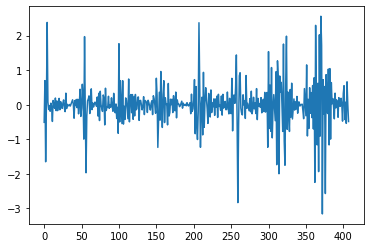

In [100]:
plt.plot(cA[0,1,:])

Get season curve

In [ ]:

yp_seas=(np.zeros(len(seas)+1))
ind = np.zeros(len(seas)+1)
mask_fct_0 = df_m.index==pd.to_datetime((ews).startdate())
yp_seas[0] = (df_m[mask_fct_0].loc[:,'lag_comp1'].values)
df_seas = pd.DataFrame()
for i in range(0,len(seas)):
    mask_fct_0 = df_m.index==pd.to_datetime((ews+i).startdate())
    mask_fct_1 = df_m.index==pd.to_datetime((ews+i+1-52).startdate()) 
    y_diff_comp = yp_seas[i]+df_m[mask_fct_1].loc[:,'diff_1'].values
    yp_seas[i+1] = seas[i]+y_diff_comp
    df_seas.loc[i+1,'seas'] = yp_seas[i+1]
    df_seas.loc[i+1,'DATE'] = pd.to_datetime((ews+i+1).startdate())
#     yp_seas.index[i+1] = pd.to_datetime((ews+i+1).startdate())
df_seas = df_seas.set_index('DATE')

In [ ]:
plt.figure(figsize=(15,8))
plt.plot((fdf[fdf['REGION']==region]['%UNWEIGHTED ILI']), label='true')
plt.plot(df_seas.seas, label='seas')
plt.plot((fdf[fdf['REGION']==region]['%UNWEIGHTED ILI'])-df_seas.seas, label='err')
# plt.plot(b,label='wght_seas')
plt.legend()
# plt.plot(df_m['true_ili'])

In [ ]:
df_seas['%UNWEIGHTED ILI'] = (fdf[fdf['REGION']==region]['%UNWEIGHTED ILI'])
df_seas['52-%UNWEIGHTED ILI'] = (fdf[fdf['REGION']==region]['%UNWEIGHTED ILI'].shift(52))
plt.plot(df_seas.seas,label='seas')
plt.plot(df_seas['%UNWEIGHTED ILI'],label='true')
plt.plot(df_seas['52-%UNWEIGHTED ILI'],label='52-true')
plt.plot(df_seas['52-%UNWEIGHTED ILI']-df_seas['seas'], label='diff_past')
plt.legend()

In [ ]:
plt.plot(df_m.loc[:,'diff_1'])
plt.plot(df_m.loc[:,'diff_1_52'])

In [ ]:
import matplotlib.pyplot as plt
for i in [1,2,3,4]:
    plt.figure(i,figsize=(10,6))
    plt.plot(df_res['{} week ahead'.format(i)], label='{} week ahead'.format(i))
    plt.plot(df_res[targ_dict['target']], label='True')
#     plt.plot(df_res[targ_dict['target']]-df_res['{} week ahead'.format(i)], label='{} week error'.format(i))
    plt.legend()
    df_err_temp = (df_res['%UNWEIGHTED ILI']-df_res['{} week ahead'.format(i)])
    mse = sum((df_err_temp.dropna())**2)/len(df_err_temp.dropna())
    plt.title("MSE={}".format(mse))

In [ ]:
df_m.loc[:,'true_ili'] = df_m.loc[:,'%UNWEIGHTED ILI']
df_m.loc[:,'%UNWEIGHTED ILI'] = a.loc[:,]
df_m.loc[:,'lag_comp'] = b.loc[:,]

In [ ]:
plt.plot(a)

In [ ]:
import matplotlib.pyplot as plt
plt.plot(df_m['%UNWEIGHTED ILI']-df_m['%UNWEIGHTED ILI'].shift())
plt.show()

In [ ]:
plt.plot(df_m['%UNWEIGHTED ILI'])
plt.plot(df_m['%UNWEIGHTED ILI'].shift(52))

In [ ]:
def get_stat_comp(df_nonstat, targ_dict, train_win_len):
    stat_targ_dict = {'target':targ_dict['target']}# target to stationarize
    dom_lags = np.array([1,50,51,52,53,54,102,103,104,105,106]) # dominant lags
    stat_win = train_win_len+np.max(dom_lags)
    coeffs_stat, yp_nonstat_comp, tr_tp, diff_stat_comp, lags_app_stat = ARLR_model_exog(df_nonstat, dom_lags, targ_dict, stat_win, 1e-4)

    diff_stat_comp = pd.Series(diff_stat_comp)
    diff_stat_comp.index = yp_nonstat_comp.index
    return diff_stat_comp, yp_nonstat_comp





In [ ]:
a,b = get_stat_comp(df_m[targ_dict['target']], targ_dict, 208)
adf = pd.DataFrame(columns=[targ_dict['target'][0],'lag_comp'], index=a.index)
adf.loc[:,'%UNWEIGHTED ILI'] = a.loc[:,]
# # adf['lag_comp'] = 0
adf.loc[:,'lag_comp'] = b.loc[:,]

In [ ]:
# year = '2018'
# ews = epi.Week(int(year), 40)

# targ_dict = {"target" : targets['ili'], "ght_target" : ['flu', 'cough', 'fever', 'influenza', 'cold'], "aw_target" : ['temperature_mean', 'AH_mean', 'cloud_cover_mean']}#, 'wind_speed_mean']}
targ_dict = {"target" : targets['ili'], "ght_target" : ['flu', 'cough', 'fever', 'influenza', 'cold'], "aw_target" : ['temperature_mean', 'AH_mean', 'cloud_cover_mean']}#, 'wind_speed_mean']}

region='District of Columbia'
mask_targ =  [targ_dict['target']]+targ_dict['aw_target']+targ_dict['ght_target']

In [ ]:
df_m = ARLR_regressor(fdf, df_wtr, df_ght, region, targ_dict, ews)
a,b = get_stat_comp(df_m[targ_dict['target']], targ_dict, 300,np.array([102,103,104,105,106]))

In [ ]:
df_s=pd.DataFrame(columns=[targ_dict['target']], index=a[::-1].index)
df_s[targ_dict['target']] = a[::-1]
# a,b = get_stat_comp(a, targ_dict, 208,np.array([1,2,3,4,5,6,7]))

In [ ]:
c,d = get_stat_comp(df_s[targ_dict['target']], targ_dict,208 ,np.array([50,51,52,53,54]))

In [ ]:
df_sp=pd.DataFrame(columns=[targ_dict['target']], index=c[::-1].index)
df_sp[targ_dict['target']] = c[::-1]

In [ ]:
e,f = get_stat_comp(df_sp[targ_dict['target']], targ_dict,208 ,np.array([1,2,3,4,5,6,7]))

In [ ]:
plt.plot(e)

In [ ]:
import matplotlib.pyplot as plt
plt.plot(df_m)
plt.plot(b)
plt.plot(a)
plt.figure()
plt.plot(a.rolling(window=10).mean())
plt.plot(a.rolling(window=10).var())

In [ ]:
for v in targ_dict.values():
    if targets['wili'] in v:
        v.remove(targets['wili'])
print(targ_dict)

In [ ]:
df_2 = (np.log(df_m['%UNWEIGHTED ILI'])-np.log(df_m['%UNWEIGHTED ILI']).shift(-1)).rolling(10)

In [102]:
cd ../data/

/Users/A.Adiga/work/Forecasting/ARLR_codes/data


In [120]:
df_wtr_nat = pd.read_csv('data-aw-whole_20191108_1605-weekly-nation.csv')
df_wtr_hhs = pd.read_csv('data-aw-whole_20191108_1605-weekly-hhs.csv')

In [108]:
df_temp = df_wtr_1.append(df_wtr)

,area_id,date,temperature_max,temperature_min,temperature_mean,RH_max,RH_min,RH_mean,wind_speed_mean,cloud_cover_mean,...,pressure_min,pressure_mean,AH_max,AH_min,AH_mean,SH_max,SH_min,SH_mean,region,region_type
0,USA,2009-12-30,43.8953,22.32260,33.022050,88.9980,46.07180,68.371600,8.096935,50.036400,...,30.0617,30.148400,5.83723,2.60016,3.963955,0.004655,0.002037,0.003132,National,National
1,USA,2010-01-06,41.1108,19.19020,30.084700,85.0744,45.99390,64.904143,7.765080,51.572171,...,29.9888,30.135943,4.81348,2.30899,3.229579,0.003811,0.001795,0.002533,National,National
2,USA,2010-01-13,53.1583,18.65260,37.522086,89.4751,41.45050,66.860571,6.064744,48.491857,...,29.9501,30.194414,7.12412,2.23467,4.374403,0.005749,0.001739,0.003463,National,National
3,USA,2010-01-20,52.8338,36.26200,43.859257,94.0958,56.99230,78.143371,7.066016,67.488729,...,29.6332,29.832957,7.87163,4.93582,6.387493,0.006397,0.003971,0.005167,National,National
4,USA,2010-01-27,53.8615,24.85080,38.364700,91.2173,46.17210,69.208829,8.387260,59.121743,...,29.5638,29.997971,8.67571,3.29949,5.003009,0.007119,0.002607,0.004016,National,National
5,USA,2010-02-03,46.9809,23.83990,37.677043,91.8050,49.25960,73.406343,6.488347,66.121714,...,29.7856,30.050814,6.97400,3.26899,5.050741,0.005638,0.002573,0.004029,National,National
6,USA,2010-02-10,44.4665,26.54760,35.178057,89.9928,50.62400,71.185871,7.227786,56.716014,...,29.7613,29.963257,6.03080,3.11508,4.313866,0.004835,0.002447,0.003420,National,National
7,USA,2010-02-17,51.7585,27.73480,39.170514,86.0314,43.93450,65.648214,7.223034,48.611829,...,29.8548,29.959800,6.03719,3.11852,4.408329,0.004840,0.002470,0.003510,National,National
8,USA,2010-02-24,52.7392,30.07120,40.227829,90.9547,46.95340,70.825800,7.628826,63.813557,...,29.7100,29.908729,7.04860,3.49803,5.051793,0.005697,0.002793,0.004045,National,National
9,USA,2010-03-03,56.8984,32.61780,42.654671,89.0715,34.01630,65.542886,7.039503,46.705057,...,29.7918,29.993886,6.36202,3.43312,4.883470,0.005115,0.002734,0.003900,National,National


In [149]:
dff = df_wtr_nat.append(df_wtr_hhs)
dff[dff.date=='2009-12-30']

,area_id,date,temperature_max,temperature_min,temperature_mean,RH_max,RH_min,RH_mean,wind_speed_mean,cloud_cover_mean,...,pressure_min,pressure_mean,AH_max,AH_min,AH_mean,SH_max,SH_min,SH_mean,region,region_type
0,USA,2009-12-30,43.8953,22.32260,33.022050,88.9980,46.0718,68.37160,8.096935,50.03640,...,30.0617,30.14840,5.83723,2.600160,3.963955,0.004655,0.002037,0.003132,National,National
0,1,2009-12-30,34.2341,18.10970,27.755600,94.5324,68.0594,84.63940,8.683130,95.75810,...,29.2813,29.67720,4.43362,1.909340,3.455450,0.003460,0.001469,0.002680,Region 1,HHS Regions
508,10,2009-12-30,47.1247,34.96550,41.389650,95.9997,72.2047,85.40160,8.811795,87.63700,...,29.8493,30.08750,7.41749,5.383980,6.265025,0.005954,0.004192,0.004965,Region 10,HHS Regions
1016,2,2009-12-30,43.4991,22.00150,34.044200,95.8411,52.1617,72.95245,10.348290,81.98230,...,29.6798,29.81565,6.39731,2.968370,4.748765,0.005143,0.002420,0.003836,Region 2,HHS Regions
1524,3,2009-12-30,39.4575,18.24400,28.480600,96.4560,40.3488,65.65825,11.948610,68.37475,...,29.8768,29.94215,5.21569,1.286180,2.851240,0.004087,0.000970,0.002205,Region 3,HHS Regions
2032,4,2009-12-30,52.7240,27.29630,39.103200,94.3585,35.1363,66.62435,8.718655,33.78540,...,30.0293,30.15645,9.08424,2.365550,4.856205,0.007381,0.001846,0.003872,Region 4,HHS Regions
2540,5,2009-12-30,21.3320,1.28727,10.910450,83.7011,52.2806,69.47250,10.073985,47.40620,...,30.1596,30.31370,2.29660,0.858317,1.401740,0.001734,0.000619,0.001036,Region 5,HHS Regions
3048,6,2009-12-30,51.6778,27.70600,39.053400,88.3047,37.3901,66.56075,5.901080,22.42845,...,30.2170,30.34970,5.47413,3.231800,4.152650,0.004294,0.002488,0.003234,Region 6,HHS Regions
3556,7,2009-12-30,18.0390,-2.89557,7.748235,84.5950,57.5495,72.19410,7.423070,44.16030,...,30.4081,30.50140,1.76529,0.803862,1.230985,0.001305,0.000572,0.000896,Region 7,HHS Regions
4064,8,2009-12-30,35.2270,11.94290,23.124000,91.7884,49.2798,69.92660,6.254645,60.17755,...,30.0908,30.24075,3.52530,1.655620,2.577070,0.002738,0.001244,0.001965,Region 8,HHS Regions


In [133]:
df_wtr_hhs['region'] = df_wtr_hhs.apply(lambda x: "Region {}".format(x['area_id']),axis=1)
df_wtr_hhs['region_type'] = df_wtr_hhs.apply(lambda x: "HHS Regions", axis=1)

In [134]:
df_wtr_nat['region'] = df_wtr_nat.apply(lambda x: "National", axis=1)
df_wtr_nat['region_type'] = df_wtr_nat.apply(lambda x: "National", axis=1)

In [145]:
df_wtr_hhs

,area_id,date,temperature_max,temperature_min,temperature_mean,RH_max,RH_min,RH_mean,wind_speed_mean,cloud_cover_mean,...,pressure_min,pressure_mean,AH_max,AH_min,AH_mean,SH_max,SH_min,SH_mean,region,region_type
0,1,2009-12-30,34.2341,18.10970,27.755600,94.5324,68.05940,84.639400,8.683130,95.758100,...,29.2813,29.677200,4.43362,1.909340,3.455450,0.003460,0.001469,0.002680,Region 1,HHS Regions
1,1,2010-01-06,37.0382,10.68450,24.053243,89.6051,37.64310,66.992643,10.311601,54.748529,...,29.1777,29.635514,3.02926,0.958543,2.315597,0.002377,0.000707,0.001787,Region 1,HHS Regions
2,1,2010-01-13,45.6138,5.30733,25.815229,87.2331,27.34830,61.366714,6.828833,38.600643,...,29.8887,30.081957,4.39362,0.820532,2.430269,0.003448,0.000606,0.001864,Region 1,HHS Regions
3,1,2010-01-20,39.4014,15.42790,30.632014,98.1333,32.85830,77.623457,6.305341,52.554600,...,29.5995,29.996986,5.35021,1.555950,3.590226,0.004193,0.001177,0.002779,Region 1,HHS Regions
4,1,2010-01-27,53.9797,4.03033,28.508900,98.2432,32.29140,64.652614,9.853119,51.601011,...,29.2607,29.906971,9.99734,0.605476,3.279270,0.008310,0.000440,0.002585,Region 1,HHS Regions
5,1,2010-02-03,33.7995,7.94959,23.509743,91.5798,23.91740,54.185943,7.355143,42.984543,...,29.6973,30.076986,3.40656,0.814442,1.820383,0.002623,0.000600,0.001381,Region 1,HHS Regions
6,1,2010-02-10,39.3372,12.02300,27.461557,91.6915,27.21430,56.017129,10.758414,37.376274,...,29.1723,29.639886,4.39960,1.212420,2.237859,0.003498,0.000908,0.001740,Region 1,HHS Regions
7,1,2010-02-17,46.5866,24.61740,33.325200,95.6292,42.24490,64.689114,10.525394,63.838271,...,29.2965,29.534257,4.45300,2.186480,3.255784,0.003521,0.001705,0.002565,Region 1,HHS Regions
8,1,2010-02-24,45.5761,26.11930,35.636057,98.4753,41.58130,80.710071,9.263961,77.828914,...,28.8377,29.671029,7.20952,2.502850,4.548827,0.005921,0.001950,0.003594,Region 1,HHS Regions
9,1,2010-03-03,54.6770,25.80090,37.013929,95.2291,19.26870,65.035671,9.810334,69.121076,...,29.4111,29.760114,4.86278,1.686750,3.686607,0.003885,0.001310,0.002905,Region 1,HHS Regions


In [189]:

def mytest(st_id_path, **kwargs):
    df_wtr = pd.DataFrame()
    df_wtr_temp = pd.DataFrame()
    for key,value in kwargs.items():
        if key == "National" and value is not None:
            df_wtr_temp = pd.read_csv(value)
            df_wtr_temp['region'] = df_wtr_temp.apply(lambda x: "National", axis=1)
            df_wtr_temp['region_type'] = df_wtr_temp.apply(lambda x: "National", axis=1)
        elif key == "HHS" and value is not None:
            df_wtr_temp = pd.read_csv(value)
            df_wtr_temp['region'] = df_wtr_temp.apply(lambda x: "Region {}".format(x['area_id']),axis=1)
            df_wtr_temp['region_type'] = df_wtr_temp.apply(lambda x: "HHS Regions", axis=1)
        elif key == "States" and value is not None:
            df_wtr_temp = pd.read_csv(value)
            df_wtr_temp = df_wtr_temp[~df_wtr_temp.area_id.isin([72,78])]
            df_st_id = pd.read_csv(st_id_path)
            df_wtr_temp['region'] = df_wtr_temp.apply(lambda row: df_st_id[df_st_id['state']==row['area_id']]['state_name'].values[0], axis=1)
            df_wtr_temp['region_type'] = df_wtr_temp.apply(lambda x: "States", axis=1)
        df_wtr = df_wtr.append(df_wtr_temp)
    pp = pd.to_datetime([epi.Week(int(cdc_data.date2ew(d.date())[0]),int(cdc_data.date2ew(d.date())[1])).startdate() for d in pd.to_datetime(df_wtr.date)])
    df_wtr.index = pp  
    df_wtr.index = df_wtr.index.rename('DATE')
    return df_wtr


In [192]:
kwargs = {"National": 'data-aw-whole_20191108_1605-weekly-nation.csv', "HHS": None, "States": 'data-aw-whole_20191108_1605-weekly-state.csv'}
st_id_path='state_fips.csv'
df_wtr_new = mytest(st_id_path,**kwargs)

In [193]:
df_wtr_new

,area_id,date,temperature_max,temperature_min,temperature_mean,RH_max,RH_min,RH_mean,wind_speed_mean,cloud_cover_mean,...,pressure_min,pressure_mean,AH_max,AH_min,AH_mean,SH_max,SH_min,SH_mean,region,region_type
DATE,,,,,,,,,,,,,,,,,,,,,
2009-12-27,USA,2009-12-30,43.8953,22.32260,33.022050,88.9980,46.0718,68.371600,8.096935,50.036400,...,30.0617,30.148400,5.83723,2.600160,3.963955,0.004655,0.002037,0.003132,National,National
2010-01-03,USA,2010-01-06,41.1108,19.19020,30.084700,85.0744,45.9939,64.904143,7.765080,51.572171,...,29.9888,30.135943,4.81348,2.308990,3.229579,0.003811,0.001795,0.002533,National,National
2010-01-10,USA,2010-01-13,53.1583,18.65260,37.522086,89.4751,41.4505,66.860571,6.064744,48.491857,...,29.9501,30.194414,7.12412,2.234670,4.374403,0.005749,0.001739,0.003463,National,National
2010-01-17,USA,2010-01-20,52.8338,36.26200,43.859257,94.0958,56.9923,78.143371,7.066016,67.488729,...,29.6332,29.832957,7.87163,4.935820,6.387493,0.006397,0.003971,0.005167,National,National
2010-01-24,USA,2010-01-27,53.8615,24.85080,38.364700,91.2173,46.1721,69.208829,8.387260,59.121743,...,29.5638,29.997971,8.67571,3.299490,5.003009,0.007119,0.002607,0.004016,National,National
2010-01-31,USA,2010-02-03,46.9809,23.83990,37.677043,91.8050,49.2596,73.406343,6.488347,66.121714,...,29.7856,30.050814,6.97400,3.268990,5.050741,0.005638,0.002573,0.004029,National,National
2010-02-07,USA,2010-02-10,44.4665,26.54760,35.178057,89.9928,50.6240,71.185871,7.227786,56.716014,...,29.7613,29.963257,6.03080,3.115080,4.313866,0.004835,0.002447,0.003420,National,National
2010-02-14,USA,2010-02-17,51.7585,27.73480,39.170514,86.0314,43.9345,65.648214,7.223034,48.611829,...,29.8548,29.959800,6.03719,3.118520,4.408329,0.004840,0.002470,0.003510,National,National
2010-02-21,USA,2010-02-24,52.7392,30.07120,40.227829,90.9547,46.9534,70.825800,7.628826,63.813557,...,29.7100,29.908729,7.04860,3.498030,5.051793,0.005697,0.002793,0.004045,National,National


In [ ]:
def test_func(i):
#     if i == 3:
#         print('uhoo')
#         continue
    return print("{}".format(i))

# def test1_func(i):
#     return print("{}".format(i+10))

# for i in range(0,10):
#     test_func(i)
#     test1_func(i)







In [221]:
def prep_ght_data(**kwargs):
    '''Prepares ght and return the corresponding dataframe. kwargs is a dictionary woth key as "national", "HHS", and/or "States" and values are the paths. Prepare this dictionary before calling this functions.'''
    df_ght = pd.DataFrame()
    for key,value in kwargs.items():
#         pdb.set_trace()
        if key == "National":
            df_ght_temp = pd.read_csv(value)                                  
            df_ght_temp['region'] = df_ght_temp.apply(lambda x: "National", axis=1)
            df_ght_temp['region_type'] = df_ght_temp.apply(lambda x: "National", axis=1)   
        elif key == "HHS":
            df_ght_temp = pd.read_csv(value)
            df_ght_temp['region'] = df_ght_temp.apply(lambda x: "Region {}".format(x['hhs']),axis=1)
            df_ght_temp['region_type'] = df_ght_temp.apply(lambda x: "HHS Regions", axis=1)
        elif key == "States":
            df_ght_temp = pd.read_csv(value)
            df_ght_temp['region'] = df_ght_temp.apply(lambda x: x['state'], axis=1)
            df_ght_temp['region_type'] = df_ght_temp.apply(lambda x: "States", axis=1)
        df_ght = df_ght.append(df_ght_temp)
#     pp = pd.to_datetime([epi.Week(int(cdc_data.date2ew(d.date())[0]),int(cdc_data.date2ew(d.date())[1])).startdate() for d in pd.to_datetime(df_ght.date)])
#     df_ght.index = pp  
    df_ght = df_ght.set_index('date')
    df_ght.index = df_ght.index.rename('DATE')
    return df_ght
    

In [222]:
kwargs = {"National": 'ght_national-201947.csv', "HHS": 'ght_hhs-201947.csv', "States": 'ght_state-201947.csv'}

df_ght = prep_ght_data(**kwargs)



In [223]:
df_ght

,Unnamed: 0,cold,cough,cty_fips,fever,flu,hhs,hhs_pops,hhs_pops_wt,influenza,isPartial,nat_pops,nat_pops_wt,pops,region,region_type,st_fips,state
DATE,,,,,,,,,,,,,,,,,,
2014-11-16,NaN,46.761748,8.399328,93501788.0,10.843478,10.658195,55.0,311368436.0,10.0,1.151071,0.0,4.102229e+07,1.0,311368436.0,National,National,1477.0,NaN
2014-11-23,NaN,36.079654,9.199933,93501788.0,11.182513,9.423364,55.0,311368436.0,10.0,1.079719,0.0,4.102229e+07,1.0,311368436.0,National,National,1477.0,NaN
2014-11-30,NaN,36.012342,9.378358,93501788.0,11.731583,13.277387,55.0,311368436.0,10.0,1.664924,0.0,4.102229e+07,1.0,311368436.0,National,National,1477.0,NaN
2014-12-07,NaN,36.719865,10.227218,93501788.0,12.557126,14.863406,55.0,311368436.0,10.0,2.124939,0.0,4.102229e+07,1.0,311368436.0,National,National,1477.0,NaN
2014-12-14,NaN,37.339260,11.128650,93501788.0,13.667533,19.736408,55.0,311368436.0,10.0,2.623607,0.0,4.102229e+07,1.0,311368436.0,National,National,1477.0,NaN
2014-12-21,NaN,38.617732,13.088030,93501788.0,15.247785,23.750427,55.0,311368436.0,10.0,2.823079,0.0,4.102229e+07,1.0,311368436.0,National,National,1477.0,NaN
2014-12-28,NaN,47.125105,13.262997,93501788.0,14.312117,27.013330,55.0,311368436.0,10.0,2.980768,0.0,4.102229e+07,1.0,311368436.0,National,National,1477.0,NaN
2015-01-04,NaN,55.891988,11.732520,93501788.0,13.871540,24.052702,55.0,311368436.0,10.0,2.830046,0.0,4.102229e+07,1.0,311368436.0,National,National,1477.0,NaN
2015-01-11,NaN,40.204308,10.421357,93501788.0,13.435825,19.753793,55.0,311368436.0,10.0,2.506992,0.0,4.102229e+07,1.0,311368436.0,National,National,1477.0,NaN


In [204]:
dd = pd.read_csv('ght_state-201947.csv')

In [227]:
targ_dict

{'target': ['%UNWEIGHTED ILI', '% WEIGHTED ILI'],
 'ght_target': ['flu', 'cough', 'fever', 'influenza', 'cold'],
 'aw_target': []}

Error plots and metric for lags (1:108)+all_exog

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# Granger test to find the realtive importance of different time series

for i in range(0,30):

    

    df_m, targ_dict = ARLR_regressor(fdf, df_wtr, df_ght, region, mask_targ, ews)
#     stnry, all_rgsr = stationarity_test(df_m, allw_lags, targ_dict, 208)
    df_gr_temp = grangers_test(df_m, allw_lags, targ_dict, 208, ews+i, verbose=False)
    if i ==0:
        df_gr = df_gr_temp
    else:
        df_gr = df_gr.append(df_gr_temp)

plt.figure(figsize=(15,6))
ax = sns.heatmap(df_gr.astype(float).transpose(), cmap='RdYlGn_r', linewidths=0.5)


In [ ]:
import seaborn as sns
for i in [0,1,2,3]:
    plt.figure(figsize=(30,10))
    ax = sns.heatmap(df_coeffs.iloc[i::4,0:107].astype(float), linewidths=0.5)

    plt.figure(figsize=(5,10))
    ax = sns.heatmap(df_coeffs.iloc[i::4,107:].astype(float), linewidths=0.5)


In [ ]:
df_gr

In [ ]:
def stationarity_test(df_m, lags, targ_dict, win):
    '''df_m: DataFrame that contains data upto forecast date, hence, for "ili" no values are present but it is present for ght and weather, exogenous variables provide a prior to forecast as they contain forecast week information''' 
    all_exog_rgsr = get_exog_reg(targ_dict)
    y = (np.flip(df_m[targ_dict['target']]))
    y_obs = y[1:win+1] # 1 shift as we will have current week data for ght and weather for which we provide forecast
    ind = y_obs.index
    y_obs = np.array(y_obs.values)
    lags_chk = list(np.array(lags).astype(int)) # lags pertaining to AR coeffs
    lags_chk_all = lags_chk+all_exog_rgsr
    all_rgsr = lags_chk+all_exog_rgsr
    lags_app = []
    
    err_old = np.linalg.norm(y_obs)#np.random.randn(win,1))
    tr_tp = np.zeros([win,len(lags_chk_all)])
    
    init_lags_len = len(lags_chk_all)
    
    for k in range(0,init_lags_len):
        err_m = np.zeros([len(lags_chk_all)])
        stnry = np.zeros([len(lags_chk_all)])
        jj = 0
        for i in lags_chk_all:            
            if str(i).isdigit(): # check if it is a lag or exog column
                result = adfuller(y[(i+1):(win+i+1)])
            else:
                exog_reg = df_m[i].values # reads the column name in the dataframe specified by name="i"
                exog_reg = exog_reg[min(lags_chk):(min(lags_chk)+win)] # Most recent date -1 week's data used for exog. variable for training 
                exog_reg = np.flip(exog_reg)
#                 pdb.set_trace()
                result = adfuller(exog_reg[0:win])
        
            stnry[jj] = result[1]
#             pdb.set_trace()
            jj+=1
    return stnry, all_rgsr

In [ ]:
df_m, targ_dict = ARLR_regressor(fdf, df_wtr, df_ght, region, mask_targ, ews)
stnry, all_rgsr = stationarity_test(df_m, [1,2,3,4,52], targ_dict, 208)

In [ ]:
dict(zip(all_rgsr, stnry))

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(15,8))
ax = sns.heatmap(df_gr.astype(float).transpose(), cmap='RdYlGn_r', linewidths=0.5)


In [ ]:
from statsmodels.tsa.stattools import grangercausalitytests
allw_lags=np.arange(1,109)
maxlag=1
test = 'ssr_chi2test'
def grangers_test(df_m, lags, targ_dict, win, ews, test='ssr_chi2test', verbose=False):    
    all_exog_rgsr = get_exog_reg(targ_dict)
    y = (df_m[targ_dict['target'][0]])[::-1]
    y_obs = y[1:win+1] # 1 shift as we will have current week data for ght and weather for which we provide forecast
    ind = y_obs.index
    y_obs = np.array(y_obs.values)
    lags_chk = list(np.array(lags).astype(int)) # lags pertaining to AR coeffs
    lags_chk_all = lags_chk+all_exog_rgsr
    all_rgsr = lags_chk+all_exog_rgsr
    lags_app = []
    
    err_old = np.linalg.norm(y_obs)#np.random.randn(win,1))
    tr_tp = np.zeros([win,len(lags_chk_all)])
    
    init_lags_len = len(lags_chk_all)
    df = pd.DataFrame(columns=all_exog_rgsr)
    

    
    for i in all_exog_rgsr:            
        if str(i).isdigit(): # check if it is a lag or exog column
            test_result = grangercausalitytests(np.array([np.array(y_obs), np.array(y[(i+1):(win+i+1)])]).T, maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            min_p_value = np.min(p_values)
            df.loc[0, i] = min_p_value
        else:
            exog_reg = df_m[i].values # reads the column name in the dataframe specified by name="i"
            exog_reg = np.flip(exog_reg)
            exog_reg = exog_reg[min(lags_chk):(min(lags_chk)+win)] # Most recent date -1 week's data used for exog. variable for training 
            test_result = grangercausalitytests(np.array([np.array(y_obs), np.array(exog_reg)]).T, maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            min_p_value = np.min(p_values)
            df.loc[0, i] = min_p_value

#             pdb.set_trace()
    df['DATE'] = pd.to_datetime(ews.startdate())
    df = df.set_index('DATE')
    return df

for ews in 
df_gr = grangers_test(df_m, allw_lags, targ_dict, 208, ews, verbose=False)

In [ ]:
df_m, targ_dict = ARLR_regressor(fdf, df_wtr, df_ght, region, mask_targ, ews)
stnry, all_rgsr = stationarity_test(df_m, allw_lags, targ_dict, 208)


In [ ]:
df_gr = pd.DataFrame(columns=all_exog_rgsr)
for ews in epi.Year(2018).iterweeks():
    if ews.week>=40:
        df_gr = grangers_test(df_m, allw_lags, targ_dict, 208, ews, verbose=False)
        

In [ ]:
y = (np.flip(df_m[targ_dict['target'][0]]))


In [ ]:

df_m.index<=ews.startdate()



In [ ]:
df_m = pd.merge(df_m,a,how='outer', left_index=True, right_index=True)

In [ ]:
adf = pd.DataFrame(columns=targ_dict['target'], index=a.index)

In [ ]:
adf.loc[:,'%UNWEIGHTED ILI'] = a.loc[:,]
adf['lag_comp'] = 0
adf.loc[:,'lag_comp'] = b.loc[:,]

In [ ]:
adf['lag_comp'] = 0

In [ ]:
adf.loc[:,'lag_comp'] = b.loc[:,]

In [ ]:
adf

In [ ]:
y1 = (np.log(df_m['%UNWEIGHTED ILI']))

In [ ]:
plt.plot(y1)
plt.plot((y1.shift()))
plt.plot((y1.shift(periods=52)))

In [ ]:
y1.shift(periods=1).tail()

In [ ]:
plt.plot((y1-y1.shift(periods=52)))

In [ ]:
load AR
'''Contains functions that correspond to the ARLR method with exogenous regressors '''
from statsmodels.tsa.ar_model import AR
import numpy as np
import statsmodels.api as sm
#import matplotlib.pyplot as plt
import pandas as pd
import pdb, os
from aw_micro import cdc_data
import datetime
import configparser
import pkg_resources
import warnings
warnings.filterwarnings('ignore')
# ARLR functions
def get_bin():    
    bin_ed= [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2.0, 2.1, 2.2, 2.3, 2.4, 2.5, 2.6, 2.7, 2.8, 2.9, 3.0, 3.1, 3.2, 3.3, 3.4, 3.5, 3.6, 3.7, 3.8, 3.9, 4.0, 4.1, 4.2, 4.3, 4.4, 4.5, 4.6, 4.7, 4.8, 4.9, 5.0, 5.1, 5.2, 5.3, 5.4, 5.5, 5.6, 5.7, 5.8, 5.9, 6.0, 6.1, 6.2, 6.3, 6.4, 6.5, 6.6, 6.7, 6.8, 6.9, 7.0, 7.1, 7.2, 7.3, 7.4, 7.5, 7.6, 7.7, 7.8, 7.9, 8.0, 8.1, 8.2, 8.3, 8.4, 8.5, 8.6, 8.7, 8.8, 8.9, 9.0, 9.1, 9.2, 9.3, 9.4, 9.5, 9.6, 9.7, 9.8, 9.9, 10.0, 10.1, 10.2, 10.3, 10.4, 10.5, 10.6, 10.7, 10.8, 10.9, 11.0, 11.1, 11.2, 11.3, 11.4, 11.5, 11.6, 11.7, 11.8, 11.9, 12.0, 12.1, 12.2, 12.3, 12.4, 12.5, 12.6, 12.7, 12.8, 12.9, 13.0, 100]
    return bin_ed
 
def get_exog_reg(targ_dict):
    all_exog_rgsr = []
    for key in targ_dict:
        if key != 'target':
            all_exog_rgsr = all_exog_rgsr+targ_dict[key]
    return all_exog_rgsr

def rgsr_to_ind(exog_rgsr, allw_lags, all_exog_rgsr):
    rgsr_ind=max(allw_lags)+1+all_exog_rgsr.index(exog_rgsr)
    return rgsr_ind

def rgsrs_to_indices(lags_app, allw_lags, all_exog_rgsr):
    rgsrs_indices = []
    for ind in lags_app:
        if str(ind).isdigit():
            rgsrs_indices.append(ind)
        else:
            rgsrs_indices.append(rgsr_to_ind(ind,allw_lags,all_exog_rgsr))
    return rgsrs_indices

def ind_to_rgsr(exog_rgsr_ind, allw_lags, all_exog_rgsr):
    rgsr_name= all_exog_rgsr[exog_rgsr_ind-(max(allw_lags)+1)]
    return rgsr_name


def indices_to_rgsrs(lags_ind, allw_lags, all_exog_rgsr):
    rgsrs_names = []
    for ind in lags_ind:
        if ind <= max(allw_lags):
            rgsrs_names.append(ind)
        else:
            rgsrs_names.append(ind_to_rgsr(ind,allw_lags,all_exog_rgsr))
    return rgsrs_names
                            

def ARLR_regressor(df, df_wtr, df_ght, region, mask_targ_dict, ews):
    '''If we have other regressors, need a for loop'''
    ews_1 = ews+1 # we need ght and weather data for forecst week, hence +1
    df_reg = df[df['REGION']==region]
    df_m = df_reg
    
    if df_wtr.empty and not df_ght.empty:
        df_m = pd.merge(df_m,df_wtr,how='outer', left_index=True, right_index=True)
        df_ght_reg = df_ght[df_ght['REGION']==region] 
        df_m = pd.merge(df_m,df_ght_reg,how='outer', left_index=True, right_index=True)
    if df_ght.empty and not df_wtr.empty:
        df_m = pd.merge(df_m,df_ght,how='outer', left_index=True, right_index=True)
        df_wtr_reg = df_wtr[df_wtr['REGION']==region]
        df_m = pd.merge(df_reg,df_wtr_reg,how='outer', left_index=True, right_index=True)
    elif not df_ght.empty and not df_wtr.empty:
        df_wtr_reg = df_wtr[df_wtr['REGION']==region]
        df_ght_reg = df_ght[df_ght['REGION']==region]
        df_m = pd.merge(df_m,df_wtr_reg,how='outer', left_index=True, right_index=True)
        df_m = pd.merge(df_m,df_ght_reg,how='outer', left_index=True, right_index=True)
    
    mask_targ = []
    for k in list(mask_targ_dict):
        mask_targ = mask_targ+(mask_targ_dict[k])
    df_m = df_m[mask_targ]
    df_m = df_m[df_m.index<=pd.to_datetime((ews_1).startdate())].fillna(1e-2)
    df_m[mask_targ_dict['target']] = np.log(df_m[mask_targ_dict['target']])
    df_m = df_m.replace(-np.inf, np.nan)
    df_m = df_m.interpolate()
    df_m[mask_targ_dict['ght_target']] = (df_m[mask_targ_dict['ght_target']])
    df_m[mask_targ_dict['aw_target']] = (df_m[mask_targ_dict['aw_target']])
    return df_m
    

def ARLR_aug_phase_exog(df_m, lags, targ_dict, win,llr_tol, ar_diff=False):
    '''df_m: DataFrame that contains data upto forecast date, hence, for "ili" no values are present but it is present for ght and weather, exogenous variables provide a prior to forecast as they contain forecast week information''' 
    all_exog_rgsr = get_exog_reg(targ_dict)
    pdb.set_trace()
    if ar_diff is False:
        y = (df_m[targ_dict['target']])
        y_det_comp = np.zeros(len(y))
        y = y[-1::-1]
    elif ar_diff:
        y,y_det_comp = get_stat_comp(df_m, targ_dict, win)
    
    ind = y.index
    try:
        y = np.array(y).reshape(len(y))
    except:
        pdb.set_trace()
    y_obs = y[1:(win+1)]#-y[2:(win+2)] # 1 shift as we will have current week data for ght and weather for which we provide forecast
    ind = ind[0:win]
    y_obs = np.array(y_obs)
    if np.linalg.norm(y_obs) == 0:
        pdb.set_trace()
    lags_chk = list(np.array(lags).astype(int)) # lags pertaining to AR coeffs
    lags_chk_all = lags_chk+all_exog_rgsr 
    all_rgsr = lags_chk+all_exog_rgsr # Need to keep a copy of lags_chk_all as it is getting updated
    lags_app = []
    err_old = np.linalg.norm(y_obs)#np.random.randn(win,1))
    tr_tp = np.zeros([win,len(lags_chk_all)])
    
    init_lags_len = len(lags_chk_all)
    
    for k in range(0,init_lags_len):
        err_m = np.zeros([len(lags_chk_all)])
        llr = np.zeros([len(lags_chk_all)])
        jj = 0
        for i in lags_chk_all:            
            if str(i).isdigit(): # check if it is a lag or exog column
                tr_tp[:,k] = y[(i+1):(win+i+1)]
            else:
                #print(i)
                exog_reg = df_m[i].values # reads the column name in the dataframe specified by name="i"
                exog_reg = np.flip(exog_reg)
                exog_reg = exog_reg[min(lags_chk):(min(lags_chk)+win)] # Most recent date -1 week's data used for exog. variable for training 
                tr_tp[:,k] = exog_reg[0:win]
                
            tr_tp_mul = np.matmul(tr_tp[:,0:(k+1)].T, tr_tp[:,0:(k+1)])
            try:
                res = sm.OLS(y_obs,tr_tp[:,0:(k+1)]).fit()
            except:
                pdb.set_trace()
            #res = sm.OLS(y_obs,tr_tp[:,0:(k+1)]).fit()   
            yp = res.predict()
            err_m[jj] = np.linalg.norm(y_obs-yp)
            llr[jj] = 2*np.log(err_old/err_m[jj])
            jj+=1
             
        imax = np.argmax(llr)
    #     p_val = chi2.sf(llr[imax],1)
    #     print(p_val)
        if llr[imax] > llr_tol:
#             pdb.set_trace()
            if str(lags_chk_all[imax]).isdigit():
                tr_tp[:,k] =y[(lags_chk[imax]+1):(win+lags_chk[imax]+1)]
            else:
                exog_reg = np.flip(exog_reg)
                exog_reg = df_m[lags_chk_all[imax]].values
                tr_tp[:,k] = exog_reg[min(lags_chk):(min(lags_chk)+win)]
                
            lags_app.append(lags_chk_all[imax])
            lags_chk_all.remove(lags_chk_all[imax])
            err_old = err_m[imax]
        else:
            break
    if k:
        res = sm.OLS(y_obs,tr_tp[:,0:(k)]).fit()
    else:
        res = sm.OLS(y_obs,tr_tp[:,0]).fit()
    yp = res.predict()
    pred_err = y_obs-yp
    return res, yp, y, tr_tp, llr, pred_err, lags_app, ind, all_rgsr,win


def ARLR_red_phase_exog(y,tr_tp,err_old, lags, res1, lags_app,ind, win, llr_tol, ar_diff=False):
    pdb.set_trace()
    if ar_diff is False:
        y = (df_m[targ_dict['target']])
        y_det_comp = np.zeros(len(y))
        y = y[-1::-1]
    elif ar_diff:
        y,y_det_comp = get_stat_comp(df_m, targ_dict, win)
    ind = y.index
    try:
        y = np.array(y).reshape(len(y))
    except:
        pdb.set_trace()
    y_obs = y[1:(win+1)]#-y[2:(win+2)] # 1 shift as we will have current week data for ght and weather for which we provide forecast
    ind = ind[0:win]
    y_obs = np.array(y_obs)
    tot_col = len(lags_app)
    if tot_col == 0:
        yp_lag1 = y_obs
        temp_tr_tp = tr_tp[:,0:tot_col]
    else:
        temp_tr_tp = tr_tp[:,0:tot_col]
        for i in range(0,tot_col+1):
            init_lag_len_new = temp_tr_tp.shape[1]
            jj = 0 
            err_m = np.zeros([len(lags_app)])
            llr = np.zeros([len(lags_app)])
            for k in range(0,tot_col):
#                 pdb.set_trace()
                if tot_col <=1:
                    break
        
                res = sm.OLS(y_obs,np.delete(temp_tr_tp,k,1)).fit()
                yp = res.predict()
                err_m[jj] = np.linalg.norm(y_obs-yp)
                llr[jj] = 2*np.log(err_old/err_m[jj])
                jj+=1
            try:
                imin = np.argmin(llr)
            except:
                pdb.set_trace()
#             if (llr[imin]>llr_tol):
#                 temp_tr_tp = np.delete(temp_tr_tp,imin,1) 
#                 lags_app.remove(lags_app[imin])
#                 err_old = err_m[imin]
# #                 pdb.set_trace()
#             else:
# #                 pdb.set_trace()
#                 break
    pdb.set_trace()
    res = sm.OLS(y_obs,temp_tr_tp).fit()
    yp = res.predict()
    pred_err = y_obs-yp
    print(lags_app)
    yp_lag1 = yp 
    return res, yp_lag1, temp_tr_tp, llr, pred_err, res1, lags_app, ind

def ARLR_model_exog(df_m, allw_lags, targ_dict, win,llr_tol=1e-3, ar_diff=False):
    res, yp_aug, y_obs, tr_tp, llr, train_pred_err, lags_app, ind, all_rgsr, win = ARLR_aug_phase_exog(df_m, allw_lags, targ_dict, win,llr_tol, ar_diff)
    resf, yp_red, tr_tp, llr, train_pred_err, res1, lags_app, ind = ARLR_red_phase_exog(y_obs,tr_tp, np.linalg.norm(train_pred_err), allw_lags, res,lags_app,ind,win,llr_tol, ar_diff) # reduction phase
    yp_train = pd.Series(yp_red)
    yp_train.index = ind[:]
    all_exog_rgsr = get_exog_reg(targ_dict)
    num_coeffs = np.max(allw_lags)+len(all_exog_rgsr)
    coeffs=np.zeros(num_coeffs+1)
#     all_rgsr = 
    rgsrs_indices = rgsrs_to_indices(lags_app, allw_lags, all_exog_rgsr)
    coeffs[rgsrs_indices] = resf.params
    return coeffs, yp_train, tr_tp, train_pred_err, lags_app

def ARLR_fct_exog(coeffs,df_m,lags_app,fct_win, wks, allw_lags, targ_dict, ar_diff=False):

    all_exog_rgsr = get_exog_reg(targ_dict)
    lags_app = lags_app[lags_app!=0].astype(int)
    lags_chk_all = indices_to_rgsrs(lags_app, allw_lags, all_exog_rgsr)
    yp_fct = np.zeros([fct_win])
    pred_err = np.zeros([fct_win])
    if ar_diff is none:
        y = (df_m[targ_dict['target']])
        y_det_comp = np.zeros(len(y))
        y = y[-1::-1]
    elif ar_diff:
        y,y_det_comp = get_stat_comp(df_m, targ_dict, win)
    ind = y.index

    y_obs = y
    y_obs = y_obs.interpolate()
    y_obs = np.array(y_obs)
    fct_var = np.zeros(len(lags_app))
    pred_win = len(coeffs) # coeffs len
#     y_obs = y[lags_app-1]
    j = 0
    for i in lags_chk_all:
            
        if str(i).isdigit(): # check if it is a lag or exog column
            fct_var[j]= y_obs[i]
        else:
            fct_var[j] = df_m[i].iloc[min(allw_lags)-1] # reads the column name in the dataframe specified by name="i"
        j+=1
#     fct_var = y
    for i in range(0,fct_win):
#         pdb.set_trace()
        yp_fct[i] = np.dot(fct_var,coeffs[lags_app])
        fct_var = np.append(yp_fct[i],fct_var[0:(len(fct_var)-1)])
    
    return yp_fct, pred_err

def multi_step_fct_exog(df_m, coeffs, lags_app, train_pred_err, allw_lags,targ_dict, ms_fct, win, Nb, bin_ed, uncer_anl=False):
    '''Using the data_frame, returns 1, 2,... ms_fct-week ahead forecast and also provides the uncertainty in estimation using bootstrap method if uncer_anl=True'''
    yp_fct=np.zeros(ms_fct)
    yb_fct=np.zeros([ms_fct,Nb])
    log_scr = np.zeros(ms_fct)
    bn_mat_bst = np.zeros([len(bin_ed)-1, ms_fct])
    bn_mat_Gaussker = np.zeros([len(bin_ed)-1, ms_fct])
    for wks in range(1,ms_fct+1):
#         pdb.set_trace()
        yp_fct[wks-1],  err = ARLR_fct_exog(coeffs[wks-1,:],df_m,lags_app[wks-1,:],1, wks, allw_lags, targ_dict)
        #train_pred_err[wks-1,:] = np.roll(train_pred_err[wks-1,:],1)# update error vector for uncertainty analy.
        #train_pred_err[wks-1,0] = data_test[wks-1]-yp_fct[wks-1]
#         pdb.set_trace()
        if uncer_anl:
#             pdb.set_trace()
            yb_fct[wks-1,:] = fct_uncert(df_m, train_pred_err[wks-1,:],coeffs[wks-1,:],lags_app[wks-1,:], win, Nb)
            log_scr[wks-1], bn_mat_bst[:, wks-1] = uncer_scr(yb_fct[wks-1,:], yp_fct[wks-1], ms_fct, Nb, bin_ed,1e-5)
            bn_mat_Gaussker[:, wks-1] = uncer_Gaussker(yp_fct[wks-1], ms_fct,train_pred_err[wks-1,:], bin_ed, 1e-5)
        print('Week: {}, Fct: {}, Bs: {}, log_scr: {}'.format(wks,np.exp(yp_fct[wks-1]), np.mean(np.exp(yb_fct[wks-1,:])), log_scr[wks-1]))
    return np.exp(yp_fct), yb_fct, log_scr, bn_mat_bst.reshape([131,ms_fct]), bn_mat_Gaussker.reshape([131,ms_fct]), train_pred_err

def rgsrs_ARLR(coeffs, lags, targ_dict, ews):    
    all_exog_rgsr = get_exog_reg(targ_dict)
    lags_chk = list(np.array(lags).astype(int)) # lags pertaining to AR coeffs
    lags_chk_all = lags_chk+all_exog_rgsr
    all_rgsr = lags_chk+all_exog_rgsr
    lags_app = []
    
    
    
    init_lags_len = len(lags_chk_all)
    df = pd.DataFrame(columns=all_rgsr)
    ms_fct_len = coeffs.shape[0]
    for p in range(0,4):
        for k in range(0,init_lags_len):
            err_m = np.zeros([len(lags_chk_all)])
            stnry = np.zeros([len(lags_chk_all)])
            jj = 0
            for i in lags_chk_all:            
                if str(i).isdigit(): # check if it is a lag or exog column
                    df.loc[p, i] = coeffs[p,i]
                else:
                    df.loc[p, i] = coeffs[p,rgsr_to_ind(i,lags,all_exog_rgsr)]

    #             pdb.set_trace()
                jj+=1
        df['DATE'] = pd.to_datetime(ews.startdate())
    return df

def ARLR_exog_module(df, df_wtr, df_ght, region, targ_dict, ews, fct_weeks, allw_lags_f, ar_diff=False):
    config = configparser.ConfigParser()
    config_file = pkg_resources.resource_filename(__name__, 'config.ini')
    config.read(config_file) 
    
    ews_train = ews
    ews_test = ews   
    #df_train = df[(df['DATE']<=pd.to_datetime(ews_train.startdate()))]
    #df_train[target] = np.array(df_train[target],float)
    #df_train[target] = df_train[target].replace(0,1e-2) # check if zeros are there in ILI data as we take log
    #df_test = df[(df['DATE']>=pd.to_datetime(ews_train.startdate()))]
    #df_test[target] = np.array(df_test[target],float)
    #df_test[target] = df_test[target].replace(0,1e-2)
    #
    #train = np.log(np.array(df_train[target],'float').astype(float))
    #test = np.log(np.array(df_test[target],'float').astype(float))
    #train = pd.Series(train)
    #train.index = df_train['DATE']
    #test = pd.Series(test)
    #test.index = df_test['DATE']
    # Multi-step forecast
    df_m  = ARLR_regressor(df, df_wtr, df_ght, region,targ_dict, ews)
    
    win = int(config['Forecasting']['win']) # Length of the historial training data to be considered
    
    fut_wks = int(config['Forecasting']['fut_wks']) # Number of weeks ahead to forecast from training data 
    ms_fct = fct_weeks # For every forecast week, give additional ms_fct weeks forecast
    
    test_win = fut_wks+ms_fct # Number of true value to be fetched (testing accuracy)
    exp_max_lags =  int(config['Forecasting']['exp_max_lags'])# expected maximum lags to be considered in the model
    llr_tol=1e-4 # log-likelihood tolerance
    
    # Uncertainty analysis
    uncer_anl = 0#int(config['CDC']['uncer_anl'])
    Nb = int(config['CDC']['Nb'])
    # create bins
    n_bins=int(config['CDC']['n_bins'])
    

    bin_ed = get_bin()
    
    # Check data for stationarity in the training data with padding
    #train_win = train[-1:(-win-exp_max_lags-1):-1] # training samples in the window period + buffer
    
    
    #result = adfuller(train_win)
    #print(result)
    #if result[1] < 0.05:
    #    print('p-val of ADF test %e' %result[1])
    #    print('Stationary signal')
    # plt.plot(train_win)
    # Check seasonality
    #season_ind = get_season(train_win,fft_len=1024,figs=False)
    # train the model
    
    max_lags = np.max(allw_lags_f)
    max_lags_with_rgsr = max_lags+len(get_exog_reg(targ_dict)) # No. of AR lags + number of exog. vr 
    coeffs=np.zeros([ms_fct,max_lags_with_rgsr+1])
    train_pred_err=np.zeros([ms_fct, win])
    yp_train=np.zeros([ms_fct, win]) 
    lags_app=np.zeros([ms_fct,max_lags_with_rgsr+1])
    # Train to obtain ARLR coeffs for all specified multi-step forecast:
    # Ex: For 1-step forecast, consider data from t-1 to t-p for training: ms_fct = 1
    # for 4-step forecast, consider data for t-4 to t-p for training: ms_fct = 4 
    # similarly for 1 season, ms_fct = 52
    for wks in range(1,ms_fct+1):
        allw_lags = allw_lags_f[(wks-1):]#np.arange(wks,max_lags+1)#np.append(np.arange(wks,5),52)#
        coeffs_temp, yp_train_temp, tr_tp1, train_pred_err_temp, lags_temp = ARLR_model_exog(df_m, allw_lags, targ_dict, win, 1e-3, ar_diff) #ARLR_model(train,allw_lags,win,llr_tol)
        yp_train[wks-1,:] = yp_train_temp
        train_pred_err[wks-1,:] = train_pred_err_temp
        all_exog_rgsr = get_exog_reg(targ_dict) 
        rgsrs_indices = rgsrs_to_indices(lags_temp, allw_lags, all_exog_rgsr)
        lags_app[wks-1,rgsrs_indices] = rgsrs_indices
        coeffs[wks-1,:] = coeffs_temp
    
    
    yp_fct=np.zeros([fut_wks,ms_fct])
    yp_fct_ch=np.zeros([fut_wks,ms_fct])
    yb_fct=np.zeros([fut_wks,ms_fct,Nb])
    log_scr = np.zeros([fut_wks, ms_fct])
    bn_mat_bst = np.zeros([fut_wks, len(bin_ed)-1, ms_fct])
    bn_mat_Gaussker = np.zeros([fut_wks, len(bin_ed)-1, ms_fct])
#     # Once trained, use the coeffs to forecast multi-steps given data frame
    
    # For obtaining uncertainty in forecast estimates (using Boot strapping), choose uncer_anl = True,  
    pdb.set_trace()
#     data_test = []#test
    for new_wks in np.arange(0,fut_wks):
#         data_frame = data_frame.append(test[new_wks:(new_wks+1)])
#         data_test = data_test[1:]
        yp_fct[new_wks,:], yb_fct[new_wks,:,:], log_scr[new_wks,:], bn_mat_bst[new_wks, :,:], bn_mat_Gaussker, train_pred_err = multi_step_fct_exog(df_m, coeffs, lags_app, train_pred_err, allw_lags,targ_dict, ms_fct, win, Nb, bin_ed, uncer_anl)
    
    #seas, err_p = ARLR_fct_exog(coeffs[0,:],train,lags_app[0,:],20, 0)
    seas = 0
    return (yp_fct), bn_mat_bst, bn_mat_Gaussker, seas, lags_app,coeffs


